In [1]:
%matplotlib inline
import caffe
import numpy as np
import matplotlib.pyplot as plt

# set display defaults
plt.rcParams['figure.figsize'] = (8, 8)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels

In [2]:
caffe.set_mode_gpu()

In [3]:
from caffe.classifier import Classifier

model_def = "/home/ubuntu/nexar/caffe/squeeze_net/deploy.prototxt"
model_weights = "/home/ubuntu/nexar/caffe/squeeze_net_trainval_manual/snapshots_p2/train_squeezenet_trainval_manual_p2__iter_3817.caffemodel"

c = Classifier(
    model_def, 
    model_weights, 
    mean=np.array([104, 117, 123]),
    raw_scale=255,
    channel_swap=(2,1,0),
    image_dims=(256, 256))

# set batch size
BATCH_SIZE = 64
c.blobs['data'].reshape(BATCH_SIZE, 3, c.blobs['data'].shape[2], c.blobs['data'].shape[3])
c.blobs['prob'].reshape(BATCH_SIZE, 3)
c.reshape()

def class_idx_to_name(idx):
    return ['none', 'red', 'green'][idx]

In [5]:
import os, random

def show_image_with_prediction(filename=None):
    images_path = '/ebs/nexar/images/'
    
    if filename is None:
        filename = random.choice(os.listdir(images_path))
    
    print filename
    image = caffe.io.load_image(images_path + filename)
    r = c.predict([image], oversample=False)
    cls = r.argmax()
    plt.imshow(image)
    plt.axis('off')
    print 'predicted class is: %s with probability: %.4f' % (class_idx_to_name(cls), r.max())
    
    return image, cls

efe571b9fd42f4ca81ee12daeea48608.jpg
predicted class is: green with probability: 1.0000


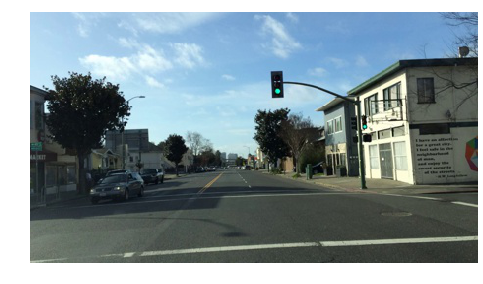

In [6]:
# f = random.choice(os.listdir(images_path))
f = 'efe571b9fd42f4ca81ee12daeea48608.jpg'

image, cls = show_image_with_prediction(f)

In [7]:
h, w, _ = image.shape
print "height:", h, "width:", w

height: 256 width: 455


In [8]:
grey_rgb = [0.5, 0.5, 0.5]

def create_patched_images(image, patch_size, step):
    patched_images = []
    patch_coords = []
    
    for i in xrange(-patch_size+1, h, step):
        for j in xrange(-patch_size+1, w, step):
            image_patched = image.copy()
            x_slice = slice(max(i, 0), min(i + patch_size, h))
            y_slice = slice(max(j, 0), min(j + patch_size, w))
            image_patched[x_slice, y_slice] = grey_rgb
            patched_images.append(image_patched)
            patch_coords.append((x_slice, y_slice))
    
    return patched_images, patch_coords

In [9]:
step = 16
patch_size = 32

patched_images, patch_coords = create_patched_images(image, patch_size, step)

(-0.5, 454.5, 255.5, -0.5)

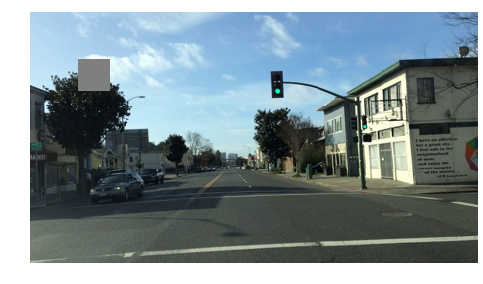

In [14]:
plt.imshow(patched_images[160])
plt.axis('off')

In [15]:
print "num images:", len(patched_images)

num images: 558


In [16]:
results = c.predict(patched_images, oversample=False)[:, cls].flatten()

In [17]:
def create_heatmap(shape, results, patch_coords, patch_size, step):
    num_patches_per_pixel = (patch_size / step) ** 2
    
    heat_map = np.zeros(shape)

    for i, p in enumerate(results):
        x_slice, y_slice = patch_coords[i]
        heat_map[x_slice, y_slice] += p / float(num_patches_per_pixel)
    
    return heat_map

In [18]:
heat_map = create_heatmap(image.shape[:2], results, patch_coords, patch_size, step)

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_color_bar(ax, im):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)

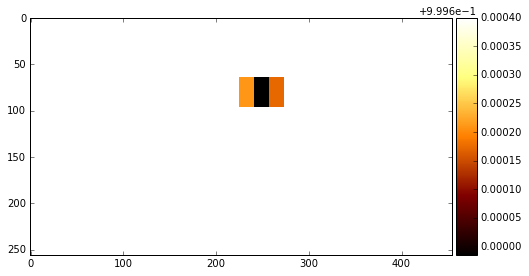

In [20]:
fig, ax = plt.subplots()
im = plt.imshow(heat_map, cmap=plt.cm.afmhot)
add_color_bar(ax, im)

In [21]:
def plot_image_with_heatmap(image, heat_map, p_min=None, p_max=None):
    fig, ax = plt.subplots()
    extent = (0, 455, 0, 256)
    ax.imshow(image, extent=extent)
    im = ax.imshow(heat_map, cmap=plt.cm.afmhot, interpolation='nearest', alpha=0.5, extent=extent, vmin=p_min, vmax=p_max)
    add_color_bar(ax, im)
    ax.axis('off')

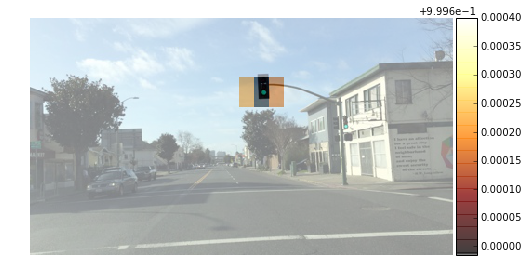

In [22]:
plot_image_with_heatmap(image, heat_map)

In [23]:
print 'Min probability of the class "green": %s' % results.min()

Min probability of the class "green": 0.999099


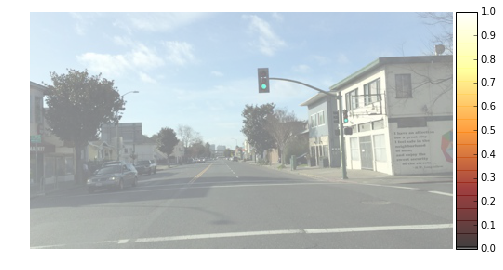

In [24]:
plot_image_with_heatmap(image, heat_map, 0, 1)

(-0.5, 454.5, 255.5, -0.5)

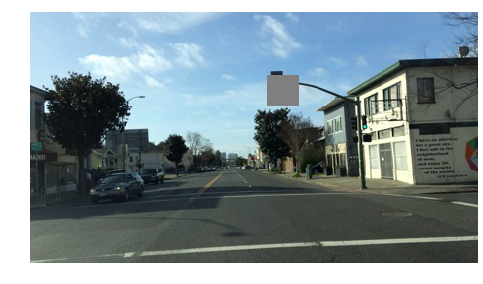

In [25]:
plt.imshow(patched_images[results.argmin()])
plt.axis('off')

In [26]:
image_with_patch = patched_images[results.argmin()]

In [27]:
patched_images, patch_coords = create_patched_images(image_with_patch, patch_size=32, step=16)
results = c.predict(patched_images, oversample=False)[:, cls].flatten()

In [28]:
heat_map = create_heatmap(image_with_patch.shape[:2], results, patch_coords, patch_size=32, step=16)

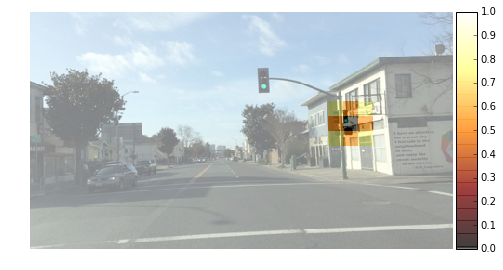

In [29]:
plot_image_with_heatmap(image, heat_map, 0, 1)

In [30]:
print 'Min probability of the class "green": %s' % results.min()

Min probability of the class "green": 0.00255422


(-0.5, 454.5, 255.5, -0.5)

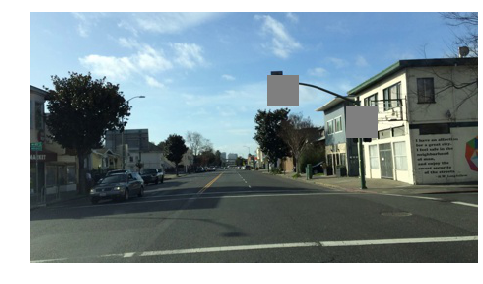

In [31]:
plt.imshow(patched_images[results.argmin()])
plt.axis('off')

In [32]:
def show_probability_heatmap(image, cls, patch_size=16, step=16, p_min=None, p_max=None):
    print "Creating patched images..."
    patched_images, patch_coords = create_patched_images(image, patch_size, step)
    print "Generating predictions..."
    results = c.predict(patched_images, oversample=False)[:, cls].flatten()
    heat_map = create_heatmap(image.shape[:2], results, patch_coords, patch_size, step)
    plot_image_with_heatmap(image, heat_map, p_min, p_max)
    
    return patched_images, results, heat_map

d6bf739b01fc54b80964545bb930f6c9.jpg
predicted class is: red with probability: 0.9283


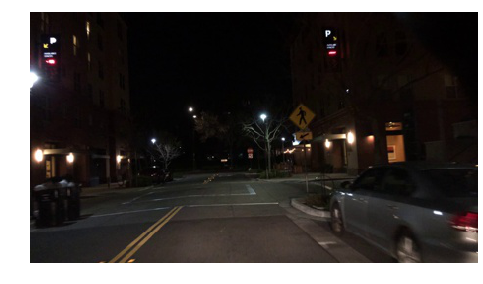

In [33]:
image, cls = show_image_with_prediction('d6bf739b01fc54b80964545bb930f6c9.jpg')

Creating patched images...
Generating predictions...


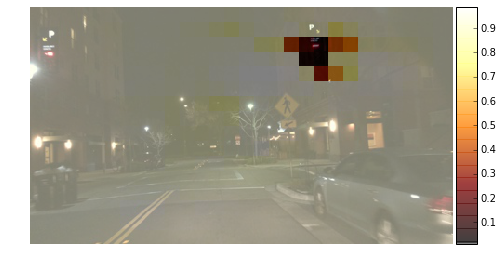

In [34]:
patched_images, results, heat_map = show_probability_heatmap(image, cls, patch_size=16, step=16)

In [35]:
results.min()

0.01149752

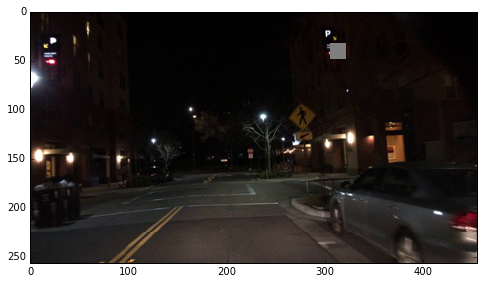

In [36]:
plt.imshow(patched_images[results.argmin()])